# SQL to Python
--------------------------------------
This notebook is for people with a solid undertsanding of SQL, trying to make a switch to Python for data science.

It shows how common SQL commands can be written in Python, and also shows how to start moving beyond just what you can do in SQL.

This notebook focuses on using Python for data analytics, with suggestions for further work later on.

I encourage you to take this notebook and run with it! Think of your own questions, and play around with the SQLite queries and Python code. You will learn much more trying to answer your own questions!

In [1]:
# importing pandas, a "SQL-like" Python library with dataframe objects built in.
import pandas as pd

Dataset is from kaggle.
https://www.kaggle.com/carrie1/ecommerce-data. You don't have to download it though, as it is already in the repo folder.

In [2]:
# Using pandas "read_csv' function to load the data.
data = pd.read_csv('ecommerce_data.csv', index_col=0, parse_dates=True)

Our data is e-commerce data from an e-commerce shop based in the UK. Most of the customers the company sells to are wholesalers.
Here, we take an initial look at our data:

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850,United Kingdom


## Making a local, server-less SQL database
[SQLite](https://www.sqlite.org/whentouse.html) is an easy-to-use SQL database system, that lets an entire database live in just one file on your computer, no server needed.

Here, we will make our own SQLite database in the repo folder, and populate with the same e-commerce data we just read into a pandas dataframe.
This way, we will be able to compare SQL commands (called to an actual SQL database) with their Python equvilents on the same data.

In [4]:
import sqlite3, os, os.path

In [5]:
# Seeing where our SQL database will be created.
os.getcwd()

'/Users/rachelberryman/Desktop/DSR_Batch_22/From_SQL_to_Python'

In [6]:
# Checking to see if a database with the same name already exists.
if os.path.isfile("E_commerce_data.db"):
    os.remove("E_commerce_data.db")

# Creating our new database, called E_commerce_data.db, and establishing a connection to it.
# We name this connection "conn". We will need to specify that connection in every SQL command we run,
# so that the queries are run on the correct database.
conn = sqlite3.connect("E_commerce_data.db")

In [7]:
# formatting the invoice date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [8]:
# populating our new SQL database with the data from our dataframe.
data.to_sql('data', conn, if_exists='replace', index=False)

Taking an initial look at our data. 

We have ~40,000 records.

In [9]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Of this, about 36,000 of them are from the UK.

In [10]:
data[data['Country']=='United Kingdom'].describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


Describe will calculate summary statistics for all of the numeric columns.
It is also a good way to see if there are non-numeric columns that are being misclassified. 
"Customer ID", which is made up of numbers, was throught to be a numeric column when the CSV was read.

### Question 1: How many countries does our company sell to?

37

In [12]:
pd.read_sql_query("""
SELECT COUNT(DISTINCT Country)
FROM data
""", conn)

,COUNT(DISTINCT Country)
0,37


### Question 2: What are our top 10 countries in terms of items sold?

Country
United Kingdom    4008533
Netherlands        200128
EIRE               136329
Germany            117448
France             109848
Australia           83653
Sweden              35637
Switzerland         29778
Spain               26824
Japan               25218
Name: Quantity, dtype: int64

In [14]:
pd.read_sql_query("""
SELECT Country, SUM(Quantity)
FROM data
GROUP BY Country
ORDER BY SUM(Quantity) desc
LIMIT 10
""", conn)

,Country,SUM(Quantity)
0,United Kingdom,4008533
1,Netherlands,200128
2,EIRE,136329
3,Germany,117448
4,France,109848
5,Australia,83653
6,Sweden,35637
7,Switzerland,29778
8,Spain,26824
9,Japan,25218



### Question 3: How much money did we make on stickers in 2017?

1139.0

In [16]:
pd.read_sql_query("""
SELECT SUM(UnitPrice * Quantity)
FROM data
WHERE Description LIKE "%STICKER SHEET%"
""", conn)

,SUM(UnitPrice * Quantity)
0,1139.0


### Question 4: How much money did we make in 2011 in the UK?

6284073.65400224

In [18]:
# SQLite doesn't have a year() function, so we have to get creative. 
# In the WHERE clause of our query, we have to format the date to just include its year component.
# You can read about date formats in SQLite here: https://www.tutorialspoint.com/sqlite/sqlite_date_time.html

pd.read_sql_query("""
SELECT SUM(UnitPrice * Quantity)
FROM data
WHERE Country = "United Kingdom" AND strftime('%Y', InvoiceDate) = '2011'
""", conn)

,SUM(UnitPrice * Quantity)
0,6.284074e+06


## More Advanced Analytics and Visualizations
#### Building a Customer Segmentation Visualization
Here, we look at how you can use Python and user-defined functions to easily manipulate your data and gleam more insights from it.

We start with adding revenue and removing canceled orders.

In [19]:
# adding revenue column
data['Revenue'] = data['UnitPrice'] * data['Quantity']

In [20]:
# removing canceled orders
data = data[data['Revenue'] > 0]

#### Step 1: group orders together by customer
- Aggregating the total number of orders they made, total quantity of all goods they've purchased, and total revenue gained.

In Python, we can use functions to transform our data. Like math functions, functions in Python take inputs, act on these inputs, and return different outputs.

In [22]:
def create_customer_table(df):
    """
    Function to group purchasing data by customer ID.
    Args:
        df (DataFrame): purchasing data
    Returns:
        customer_df (DataFrame): dataframe of customer data, where each customer gets one row.
    """
    
    # create initial customer dataframe, with just number of orders (found by counting invoices for that customer)
    customer_df = df.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
    
    # add initial metrics to the customer dataframe: total metrics, sum of float values
    for indicator in ['Quantity', 'Revenue']:
        new_col = df.groupby(by='CustomerID', as_index=False)[indicator].sum()
        customer_df = customer_df.merge(new_col, how='inner', right_on='CustomerID', left_on='CustomerID')
    
    # renaming the customer dataframe columns
    customer_df.columns = ['CustomerID', 'NumberOrders', 'TotalQuantity', 'TotalRevenue']
    
    return customer_df

Taking a look at our initial customer table we make by calling our user-defined function "create_customer_table()" on our initial dataframe:

In [23]:
customer_df = create_customer_table(data)
customer_df.tail()

,CustomerID,NumberOrders,TotalQuantity,TotalRevenue
4333,18280,10,45,180.60
4334,18281,7,54,80.82
4335,18282,12,103,178.05
4336,18283,756,1397,2094.88
4337,18287,70,1586,1837.28


#### Step 2: Calculating some additional metrics

Here, we make a more invloved user-defined function to add additional metrics based on the InvoiceDate column. We can easily make and drop columns just used for calculation within the function, that are never added to our final customer table. 

In [24]:
def calculate_customer_loyalty_metris(customer_df, df):
    """
    Function for calculating additional measures of customer loyalty.
    Args:
        customer_df (DataFrame): dataframe with customer info (1/customer)
        df (DataFrame): Original dataframe with all orders
        
    Returns:
        customer_df (DataFrame): customer_df updated to include the new customer metrics
    """
    # Step 1: create temporary dfs with groupby for both the min and max invoice dates.
    first_order = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].min()
    first_order.columns = ['CustomerID', 'FirstOrder']
    
    last_order = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
    last_order.columns = ['CustomerID', 'LastOrder']
    
    # Using a merge to combine the 2. This is just like a join in SQL.
    customer_metrics = first_order.merge(last_order, how='inner', right_on='CustomerID', left_on='CustomerID')
    
    # Adding column to use when calculating
    customer_metrics['Current'] = pd.to_datetime((df['InvoiceDate']).max())
    
    # Adding customer loyalty metrics
    customer_metrics['CustomerTimeLength'] = 1 + (customer_metrics['Current']
                                                  - customer_metrics['FirstOrder']).astype('timedelta64[D]')

    customer_metrics['DaysSinceLastOrder'] = 1 + (customer_metrics['Current'] -
                                                 customer_metrics['LastOrder']).astype('timedelta64[D]')

    # dropping column we only used in calculating
    customer_metrics.drop(['Current', 'FirstOrder', 'LastOrder'], axis=1, inplace=True)
    
    # joining the table with the customer_df table
    customer_df = customer_df.merge(customer_metrics, how='inner', right_on='CustomerID', left_on='CustomerID')

    return customer_df

In [25]:
customer_df = calculate_customer_loyalty_metris(customer_df, data)

# using iloc to select a random few rows to look at.
customer_df.iloc[3:10]

,CustomerID,NumberOrders,TotalQuantity,TotalRevenue,CustomerTimeLength,DaysSinceLastOrder
3,12349,73,631,1757.55,19.0,19.0
4,12350,17,197,334.40,310.0,310.0
5,12352,85,536,2506.04,297.0,36.0
6,12353,4,20,89.00,204.0,204.0
7,12354,58,530,1079.40,232.0,232.0
8,12355,13,240,459.40,214.0,214.0
9,12356,59,1591,2811.43,326.0,23.0


Now, we have more metrics to look into.

We can look at the average of each of these metrics, and define categories with them. (Again, we can ignore CustomerID, as we know this is a catergoric value, not a true numeric one)

In [25]:
print('Mean values of each metric \n', customer_df.describe().iloc[1])
customer_df.describe()

Mean values of each metric 
 CustomerID            15300.408022
NumberOrders             91.720609
TotalQuantity          1191.289073
TotalRevenue           2054.266460
CustomerTimeLength      223.308207
DaysSinceLastOrder       92.536422
Name: mean, dtype: float64


,CustomerID,NumberOrders,TotalQuantity,TotalRevenue,CustomerTimeLength,DaysSinceLastOrder
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.720609,1191.289073,2054.266460,223.308207,92.536422
std,1721.808492,228.785094,5046.081546,8989.230441,117.886471,100.014169
min,12346.000000,1.000000,1.000000,3.750000,1.000000,1.000000
25%,13813.250000,17.000000,160.000000,307.415000,113.000000,18.000000
50%,15299.500000,41.000000,379.000000,674.485000,249.000000,51.000000
75%,16778.750000,100.000000,992.750000,1661.740000,327.000000,142.000000
max,18287.000000,7847.000000,196915.000000,280206.020000,374.000000,374.000000


For most of the metrics, the mean far exceeds the median. This means that there are probably a few big customers (outliers) oredering a lot, and providing a lot more business than the average.

#### Step 3: Use metrics to segment customers

Since we know we have some big customers pulling up the averages of our revenue, quantity sold and number of orders, we can create a boolean column for cusotomers that exceed this average. <br>
We could also have made a boolean for customers that exceed a different threshold, say, the 70th percentile. This is up to what makes sense for the use case and with the business data.

In [26]:
def check_for_outliers(row, metric, cutoff):
    # helper function for creating customer segments
    if row[metric] > cutoff:
        return 'Yes'
    else:
        return 'No'

def create_customer_segments(customer_df):
    # function goes through each of the metric, checks for outliers, and returns a boolean ('Yes' or 'No')
    # if the row contains an outlier for that metric.
    for metric in list(customer_df.columns)[1:]:
        cutoff = customer_df[metric].mean()
        customer_df[metric + 'Outlier'] = customer_df.apply(lambda x: check_for_outliers(x, metric, cutoff), axis=1)
    return customer_df

In [27]:
customer_df = create_customer_segments(customer_df)

customer_df.iloc[10:15]

,CustomerID,NumberOrders,TotalQuantity,TotalRevenue,CustomerTimeLength,DaysSinceLastOrder,NumberOrdersOutlier,TotalQuantityOutlier,TotalRevenueOutlier,CustomerTimeLengthOutlier,DaysSinceLastOrderOutlier
10,12357,131,2708,6207.67,33.0,33.0,Yes,Yes,Yes,No,No
11,12358,19,248,1168.06,151.0,2.0,No,No,No,No,No
12,12359,248,1622,6372.58,332.0,58.0,Yes,Yes,Yes,Yes,No
13,12360,129,1165,2662.06,201.0,52.0,Yes,No,Yes,No,No
14,12361,10,91,189.90,287.0,287.0,No,No,No,Yes,Yes


If a customer has a higher-than-average number of orders, total quantity, and total revenue, and has been a customer for longer than the average (is an outlier in these categories), we can call them a "Best Customer". If the customer's time since last order is greater than the average, we can assume they are an "Inactive Customer". We will make a final column called "Customer Segments" where we place customers into one of 3 segments: a Best Customer, an Inactive Customer, and an Average Customer.

In [28]:
def classify_customers(row):
    # helper function for creating customer classifications
    if (row['NumberOrdersOutlier'] == 'Yes' 
        and row['TotalQuantityOutlier'] == 'Yes' 
        and row['TotalRevenueOutlier'] == 'Yes' 
        and row['CustomerTimeLengthOutlier'] == 'Yes'):
        
        return 'Best Customer'
    
    elif row['DaysSinceLastOrderOutlier'] == 'Yes':
        
        return 'Inactive Customer'
    
    else:
        return 'Average Customer'

    
def create_customer_classifications(customer_df):
    customer_df['CustomerSegment'] = customer_df.apply(classify_customers, axis=1)
    return customer_df

In [29]:
customer_df = create_customer_classifications(customer_df)

customer_df.iloc[0:5]

,CustomerID,NumberOrders,TotalQuantity,TotalRevenue,CustomerTimeLength,DaysSinceLastOrder,NumberOrdersOutlier,TotalQuantityOutlier,TotalRevenueOutlier,CustomerTimeLengthOutlier,DaysSinceLastOrderOutlier,CustomerSegment
0,12346,1,74215,77183.60,326.0,326.0,No,Yes,Yes,Yes,Yes,Inactive Customer
1,12347,182,2458,4310.00,367.0,2.0,Yes,Yes,Yes,Yes,No,Best Customer
2,12348,31,2341,1797.24,358.0,75.0,No,Yes,No,Yes,No,Average Customer
3,12349,73,631,1757.55,19.0,19.0,No,No,No,No,No,Average Customer
4,12350,17,197,334.40,310.0,310.0,No,No,No,Yes,Yes,Inactive Customer


#### Step 4: Visualizations

Now, we can do some visualizations with the data.

We will use [Seaborn](https://seaborn.pydata.org/index.html), a great Python library for making visualizations.

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
sorted_customer_df = customer_df.sort_values(by='TotalRevenue').reset_index()
sorted_customer_df['index'] = sorted_customer_df.index

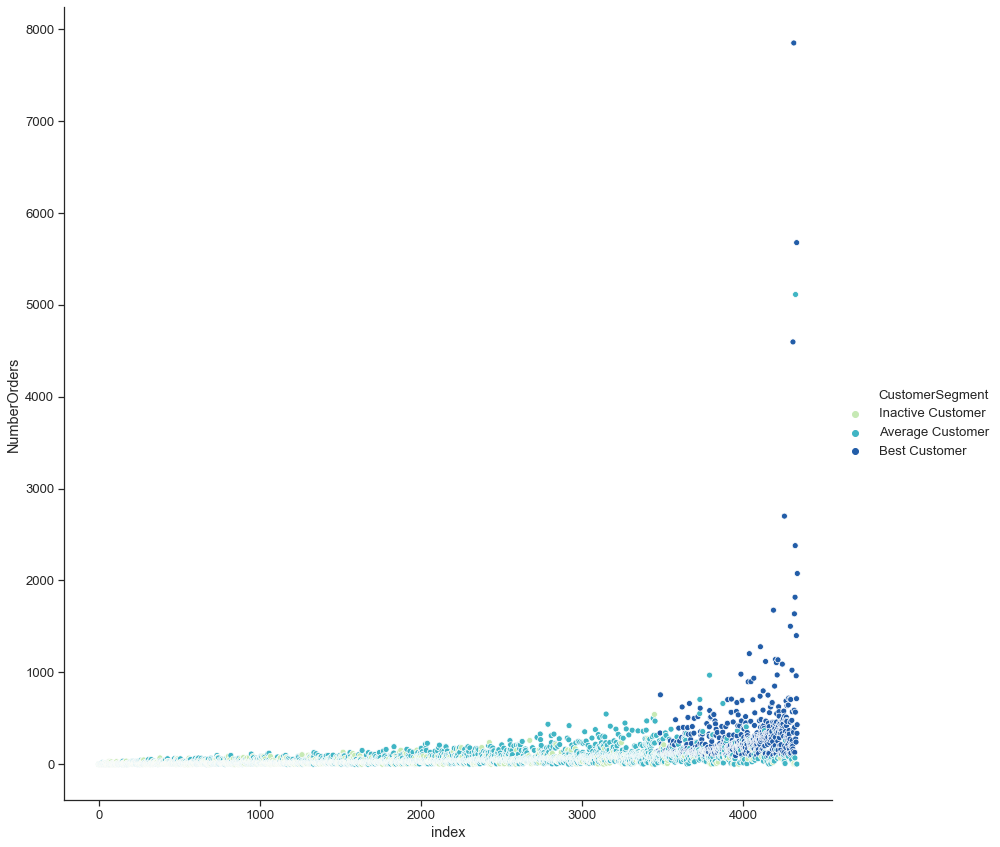

In [32]:
sns.set(style='ticks', font_scale = 1.2)
g = sns.relplot(x='index',
                y="NumberOrders",
                hue="CustomerSegment",
                data=sorted_customer_df,
                height=12,
               palette="YlGnBu")

g;

The following visualization means that many of of our best customers have a low number of days since their last order (ie have ordered recently), as we would expect. It also shows that for many of our imbalanced customers, the number of days since their last order is equal to the customer length, meaning they only ordered from us once. This also makes sense.

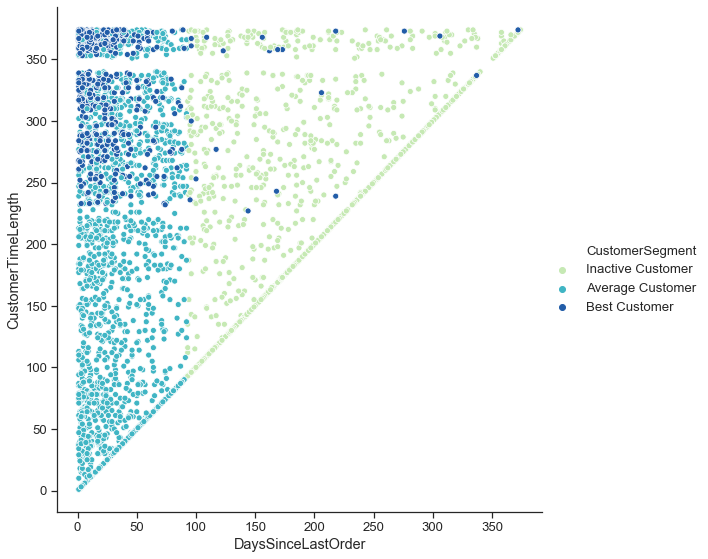

In [33]:
sns.relplot(x='DaysSinceLastOrder',
            y='CustomerTimeLength',
            data=sorted_customer_df,
            hue="CustomerSegment",
            palette="YlGnBu",
            height=8);

Here, we make a final visualization comparing the nominal share of each customer segment (how many customers each segment contains) with the share of revenue of that segment. We see that even though Best Customers are by far the smallest segment, they bring in by far the largest share of revenue.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

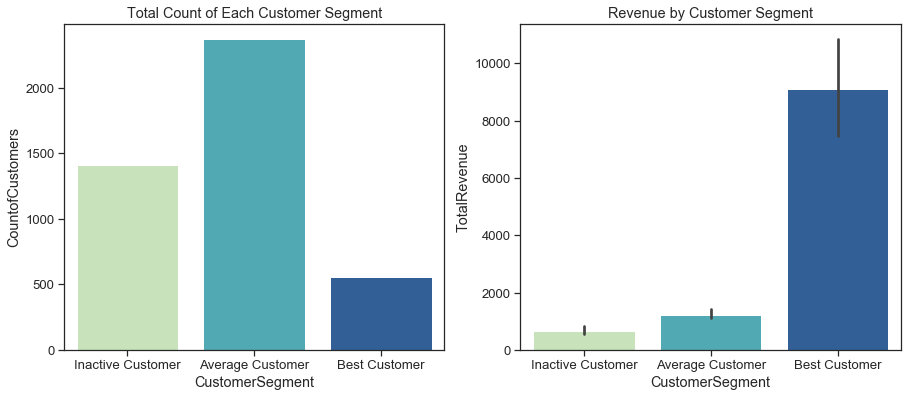

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6),)
sns.countplot(x="CustomerSegment", data=sorted_customer_df, palette="YlGnBu", ax=ax1)
sns.barplot(x="CustomerSegment", y="TotalRevenue", data=sorted_customer_df, palette="YlGnBu", ax=ax2)
ax1.set_title('Total Count of Each Customer Segment')
ax1.set_ylabel('CountofCustomers')
ax2.set_title('Revenue by Customer Segment')
;

Some ideas for this data analysis portion came from [here](https://www.kaggle.com/carrie1/customer-insights/notebook).<br> <br>


## Ideas for Next Steps:
- Write your own questions, and practice going between the SQL queries and Python/Pandas code.
- You can look at what other people have done with this data, for example [here](https://www.kaggle.com/fabiendaniel/customer-segmentation). 
- Try clustering using [unsupervised learning](http://scikit-learn.org/stable/modules/clustering.html) instead. 
- Use tools from NLP to get more insights from the product descriptions, for example [stemming](https://www.nltk.org/api/nltk.stem.html).